## Analysis and Comparision of Beliefs across the Ops

In [1]:
from polygraphs.analysis import Processor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest

import networkx as nx

/Users/prudhvivuda/Documents/polygraphs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
processor = Processor(["../../../CollegeMSG/"], config_check=False)
processor.add_config("reliability")

In [3]:
# Collect Belief Data
beliefs = pd.DataFrame()

for sim in processor.sims.iterrows():
    _ = processor.beliefs[sim[0]].copy()
    _["sim"] = sim[0]
    _["op"] = sim[1].op
    _["reliability"] = sim[1].reliability
    beliefs = pd.concat([beliefs, _])

In [4]:
# Aggregate Beliefs at Graph Level 
aggregated_beliefs = (
    beliefs.groupby(["op", "iteration"])
    .agg(
        mean_beliefs=("beliefs", "mean"),
        median_beliefs=("beliefs", "median"),
        std_beliefs=("beliefs", "std"),
        min_beliefs=("beliefs", "min"),
        max_beliefs=("beliefs", "max"),
        p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
        p75_beliefs=("beliefs", lambda x: x.quantile(0.75))
    )
    .reset_index()
)

In [5]:
aggregated_beliefs

,op,iteration,mean_beliefs,median_beliefs,std_beliefs,min_beliefs,max_beliefs,p25_beliefs,p75_beliefs
0,BalaGoyalOp,0,0.499408,0.499355,0.288425,0.000006,0.999983,0.249112,0.74951
1,BalaGoyalOp,1,0.500695,0.50094,0.290212,0.000008,0.999982,0.247771,0.754314
2,BalaGoyalOp,100,0.549492,0.577514,0.334699,0.0,1.0,0.240645,0.873266
3,BalaGoyalOp,200,0.584292,0.641665,0.346922,0.0,1.0,0.262126,0.929545
4,BalaGoyalOp,300,0.613346,0.699643,0.352041,0.0,1.0,0.289662,0.963901
...,...,...,...,...,...,...,...,...,...
1507,UnreliableNetworkModifiedAlignedNegativeEpsOp,24600,0.795627,0.999981,0.352806,0.0,1.0,0.743797,1.0
1508,UnreliableNetworkModifiedAlignedNegativeEpsOp,24700,0.795372,0.999982,0.352971,0.0,1.0,0.744057,1.0
1509,UnreliableNetworkModifiedAlignedNegativeEpsOp,24800,0.797065,0.999983,0.35166,0.0,1.0,0.751271,1.0
1510,UnreliableNetworkModifiedAlignedNegativeEpsOp,24900,0.798718,0.999984,0.350696,0.0,1.0,0.76042,1.0


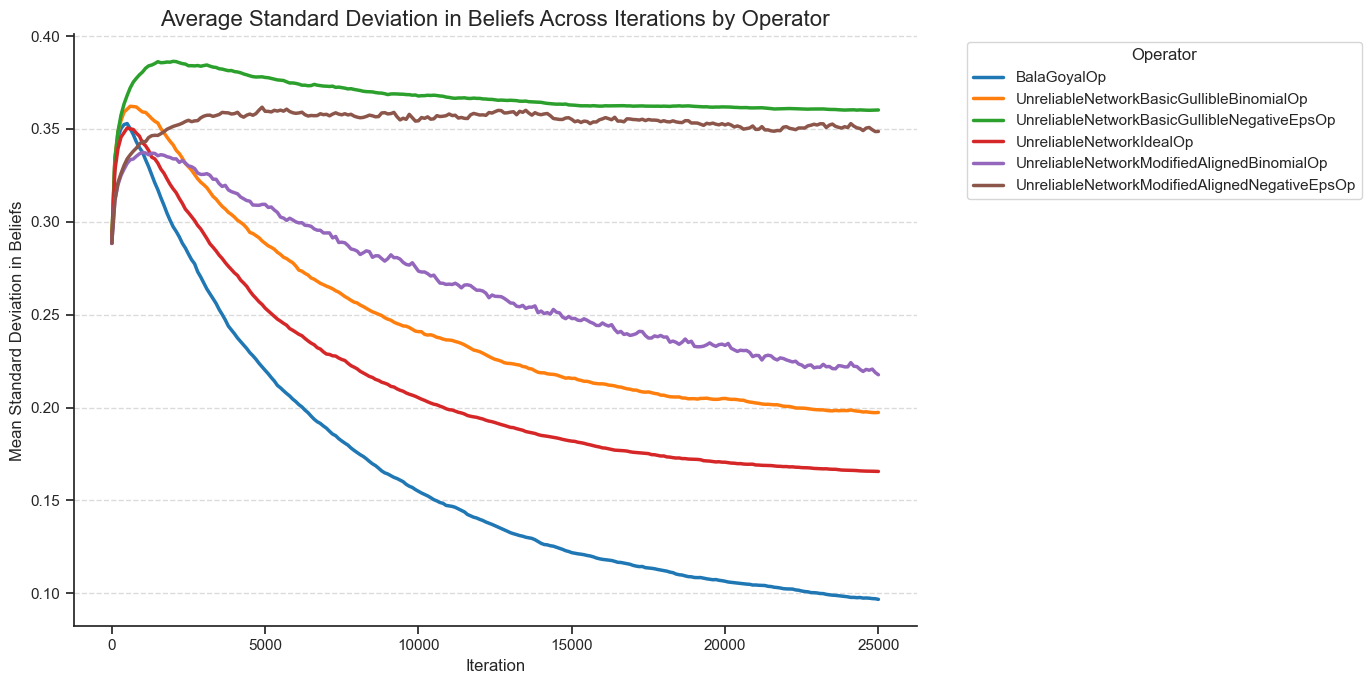

In [6]:
# Compute standard deviation of beliefs for each simulation and iteration, grouped by operator
std_per_sim_op = (
    beliefs.groupby(["op", "sim", "iteration"])["beliefs"]
    .std()
    .reset_index()
    .rename(columns={"beliefs": "std_beliefs"})
)

# Compute the average standard deviation across simulations for each iteration, grouped by operator
avg_std_by_op_iteration = (
    std_per_sim_op.groupby(["op", "iteration"])["std_beliefs"]
    .mean()
    .reset_index()
    .rename(columns={"std_beliefs": "mean_std_beliefs"})
)

# Plot the result, separating curves by operator
sns.set_theme(style="ticks")
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=avg_std_by_op_iteration,
    x="iteration",
    y="mean_std_beliefs",
    hue="op",
    palette="tab10",
    lw=2.5
)

# Add titles and labels
plt.title("Average Standard Deviation in Beliefs Across Iterations by Operator", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Mean Standard Deviation in Beliefs", fontsize=12)
plt.legend(title="Operator", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine()

# Show the plot
plt.tight_layout()
plt.savefig("images/avg std in beliefs across iterations by Op.png", format="png", dpi=300, bbox_inches="tight")
plt.savefig("images/avg std in beliefs across iterations by Ops.svg", format="svg", bbox_inches="tight")
plt.show()

In [7]:
# Compute standard deviation of beliefs for each simulation and iteration
std_per_sim = beliefs.groupby(["sim", "iteration"])["beliefs"].std().reset_index()
std_per_sim.rename(columns={"beliefs": "std_beliefs"}, inplace=True)
std_per_sim.head()

,sim,iteration,std_beliefs
0,0,0,0.288519
1,0,1,0.289007
2,0,100,0.307802
3,0,200,0.320525
4,0,300,0.324544


In [8]:
# Compute the average standard deviation across simulations for each iteration
avg_std_by_iteration = std_per_sim.groupby("iteration")["std_beliefs"].mean().reset_index()
avg_std_by_iteration.rename(columns={"std_beliefs": "mean_std_beliefs"}, inplace=True)
avg_std_by_iteration.head()

,iteration,mean_std_beliefs
0,0,0.288759
1,1,0.290025
2,100,0.325717
3,200,0.337513
4,300,0.343523


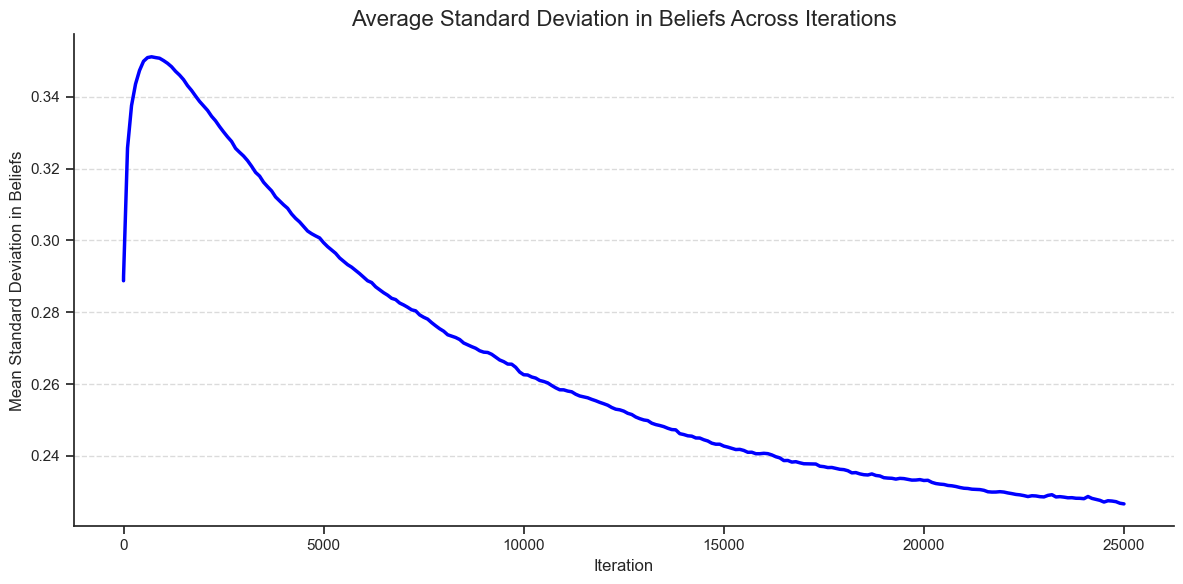

In [9]:
# Plot the result
sns.set_theme(style="ticks")
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_std_by_iteration, x="iteration", y="mean_std_beliefs", color="blue", lw=2.5)

# Add titles and labels
plt.title("Average Standard Deviation in Beliefs Across Iterations", fontsize=16)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Mean Standard Deviation in Beliefs", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine()

# Show the plot
plt.tight_layout()
plt.savefig("images/avg std in beliefs across iterations.png", format="png", dpi=300, bbox_inches="tight")
plt.savefig("images/avg std in beliefs across iterations.svg", format="svg", bbox_inches="tight")
plt.show()


In [10]:
# Compute the average standard deviation across sims at each iteration and add to aggregated_beliefs
aggregated_std = (
    std_per_sim.groupby("iteration")
    .agg(mean_std_beliefs=("std_beliefs", "mean"))
    .reset_index()
)

# Merge with aggregated_beliefs for iteration-level aggregation
aggregated_beliefs = pd.merge(aggregated_beliefs, aggregated_std, on="iteration", how="left")


In [11]:
aggregated_beliefs

,op,iteration,mean_beliefs,median_beliefs,std_beliefs,min_beliefs,max_beliefs,p25_beliefs,p75_beliefs,mean_std_beliefs
0,BalaGoyalOp,0,0.499408,0.499355,0.288425,0.000006,0.999983,0.249112,0.74951,0.288759
1,BalaGoyalOp,1,0.500695,0.50094,0.290212,0.000008,0.999982,0.247771,0.754314,0.290025
2,BalaGoyalOp,100,0.549492,0.577514,0.334699,0.0,1.0,0.240645,0.873266,0.325717
3,BalaGoyalOp,200,0.584292,0.641665,0.346922,0.0,1.0,0.262126,0.929545,0.337513
4,BalaGoyalOp,300,0.613346,0.699643,0.352041,0.0,1.0,0.289662,0.963901,0.343523
...,...,...,...,...,...,...,...,...,...,...
1507,UnreliableNetworkModifiedAlignedNegativeEpsOp,24600,0.795627,0.999981,0.352806,0.0,1.0,0.743797,1.0,0.227514
1508,UnreliableNetworkModifiedAlignedNegativeEpsOp,24700,0.795372,0.999982,0.352971,0.0,1.0,0.744057,1.0,0.227431
1509,UnreliableNetworkModifiedAlignedNegativeEpsOp,24800,0.797065,0.999983,0.35166,0.0,1.0,0.751271,1.0,0.227259
1510,UnreliableNetworkModifiedAlignedNegativeEpsOp,24900,0.798718,0.999984,0.350696,0.0,1.0,0.76042,1.0,0.226817


In [12]:
ops = aggregated_beliefs["op"].unique()
results = pd.DataFrame()

for idx, op in enumerate(ops):
    for other_op in ops[idx + 1:]:
        # Compare distributions of mean beliefs
        test_result = kstest(
            aggregated_beliefs[aggregated_beliefs["op"] == op]["mean_beliefs"],
            aggregated_beliefs[aggregated_beliefs["op"] == other_op]["mean_beliefs"]
        )
        # Store results
        results = pd.concat([
            results,
            pd.DataFrame({
                "comparison": [f"{op} vs {other_op}"],
                "statistic": test_result.statistic,
                "pvalue": test_result.pvalue
            })
        ])

pd.options.display.float_format = "{:,.4f}".format
print(results.set_index("comparison"))

                                                    statistic  pvalue
comparison                                                           
BalaGoyalOp vs UnreliableNetworkBasicGullibleBi...     0.6706  0.0000
BalaGoyalOp vs UnreliableNetworkBasicGullibleNe...     0.9087  0.0000
BalaGoyalOp vs UnreliableNetworkIdealOp                0.6349  0.0000
BalaGoyalOp vs UnreliableNetworkModifiedAligned...     0.7619  0.0000
BalaGoyalOp vs UnreliableNetworkModifiedAligned...     0.9286  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.8452  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.3095  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.4960  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.8849  0.0000
UnreliableNetworkBasicGullibleNegativeEpsOp vs ...     0.8730  0.0000
UnreliableNetworkBasicGullibleNegativeEpsOp vs ...     0.7222  0.0000
UnreliableNetworkBasicGullibleNegativeEpsOp vs ...     0.6111  0.0000
UnreliableNetworkIde

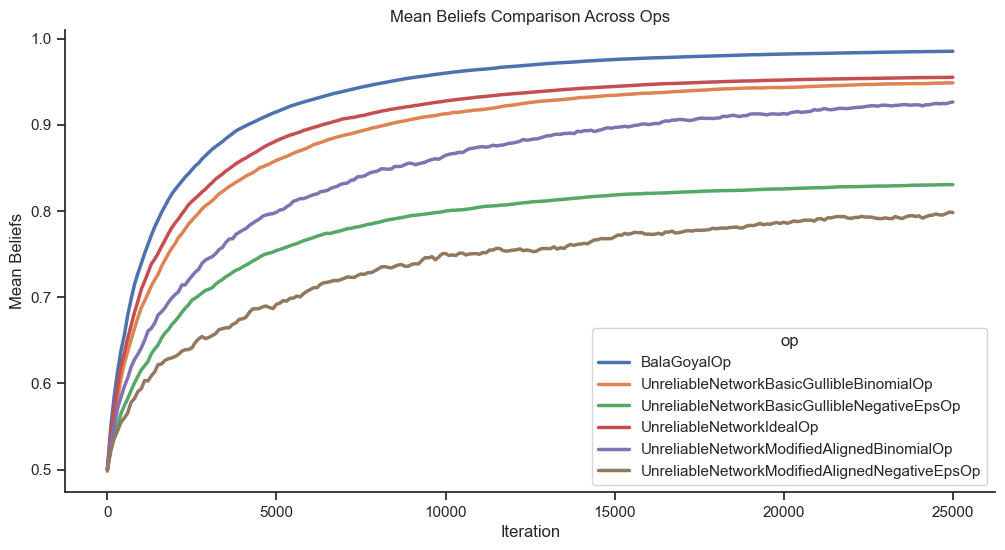

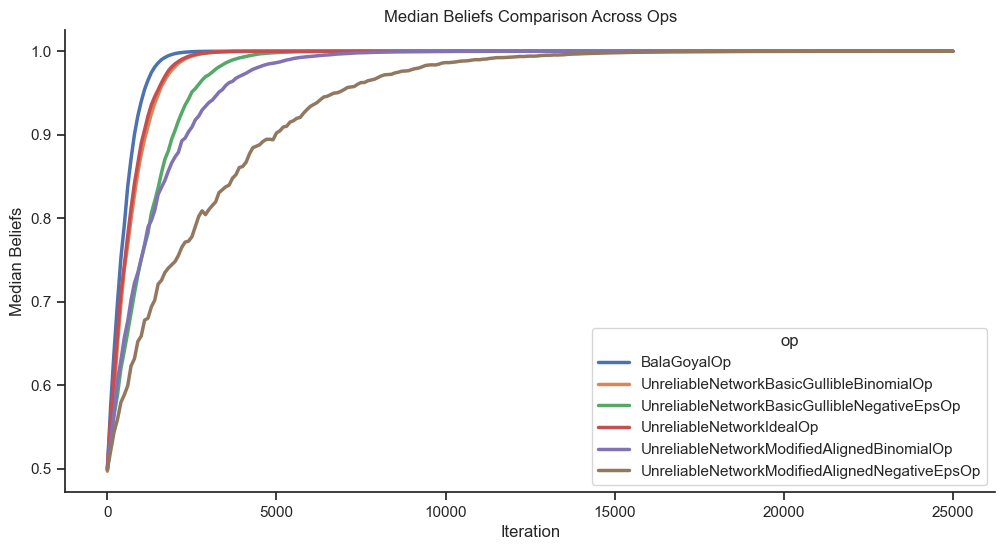

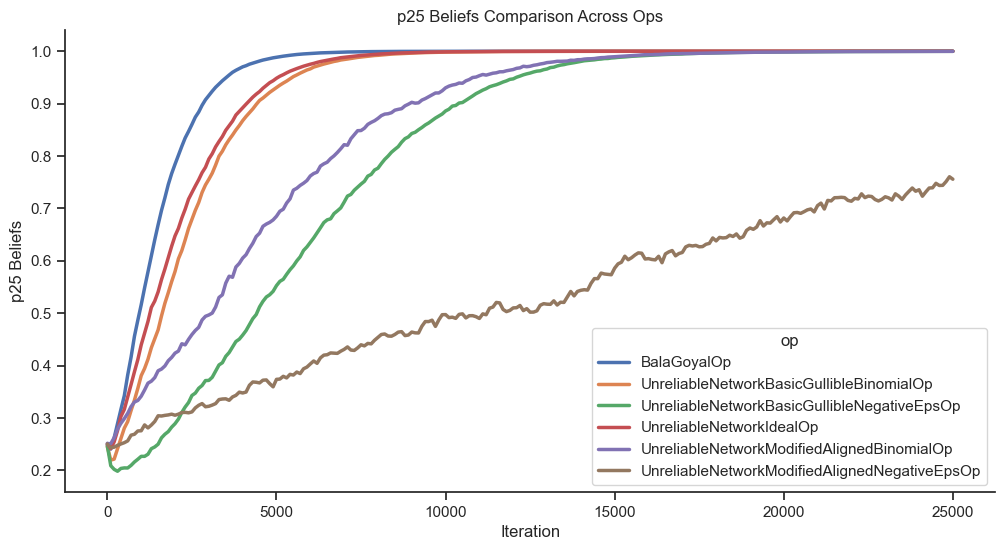

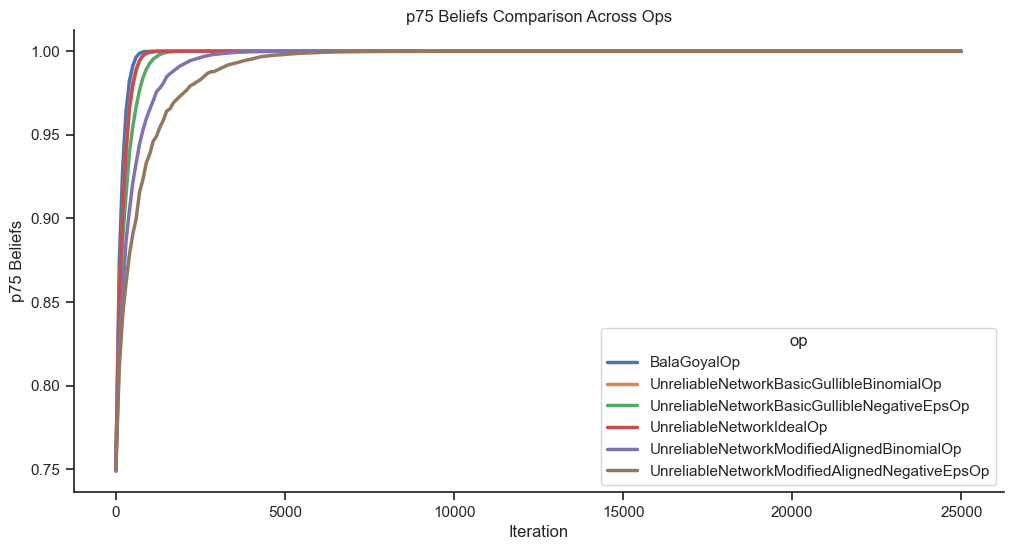

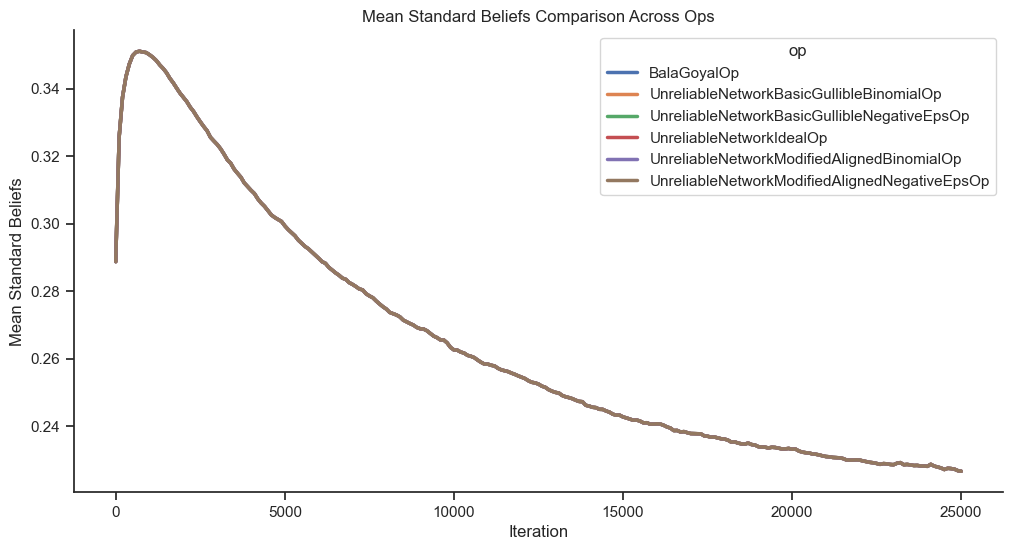

In [13]:
beliefs = {
    'mean_beliefs': 'Mean Beliefs', 
    'median_beliefs': 'Median Beliefs', 
    "p25_beliefs": 'p25 Beliefs', 
    "p75_beliefs": 'p75 Beliefs',
    "mean_std_beliefs": 'Mean Standard Beliefs'
}

for key, value in beliefs.items():
    sns.set_theme(style="ticks")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=aggregated_beliefs,
                x="iteration",
                y=key,
                hue="op",
                lw=2.5)
    plt.title(f"{value} Comparison Across Ops")
    plt.ylabel(value)
    plt.xlabel("Iteration")
    sns.despine()
    plt.savefig(f"images/{value} beliefs comparision across Ops.png", format="png", dpi=300, bbox_inches="tight")
    plt.savefig(f"images/{value} beliefs comparision across Ops.svg", format="svg", bbox_inches="tight")
    plt.show()

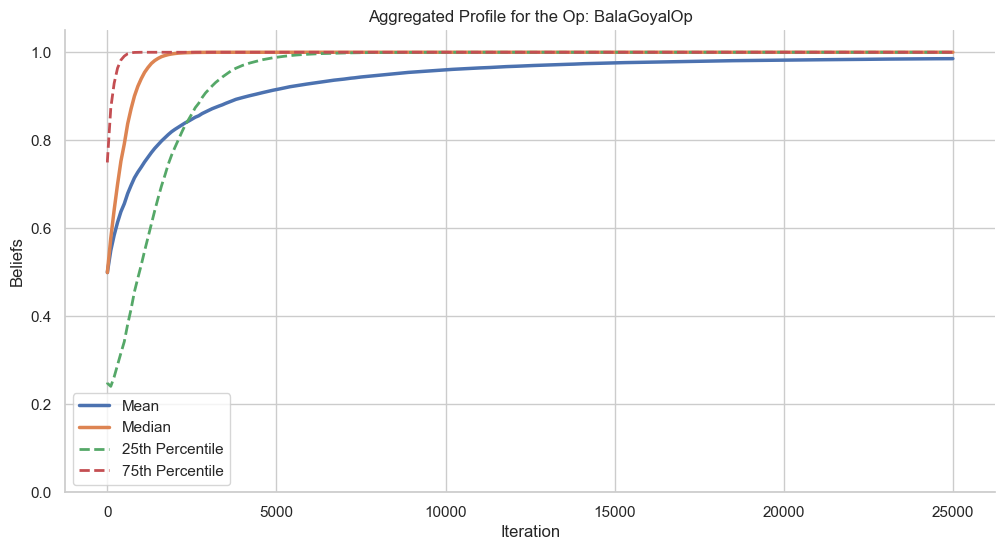

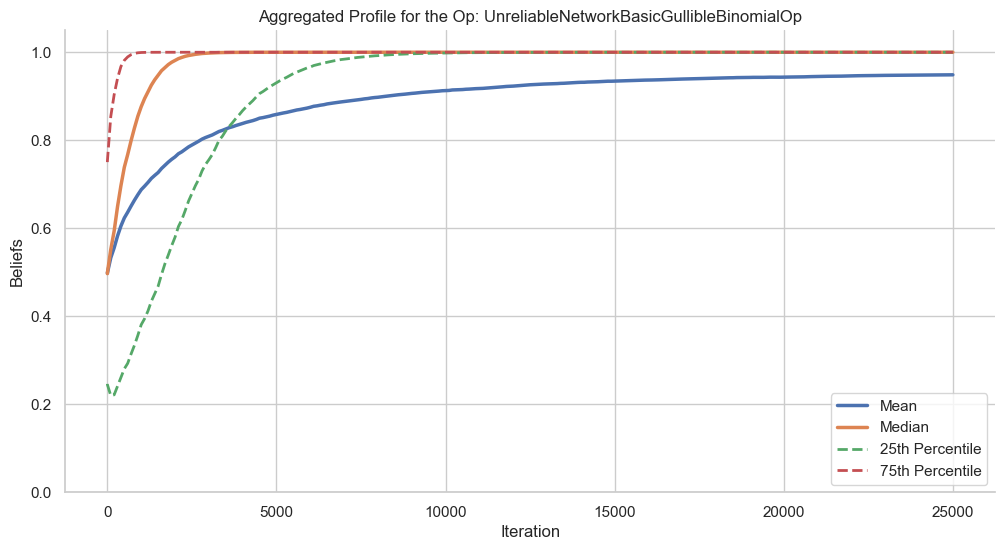

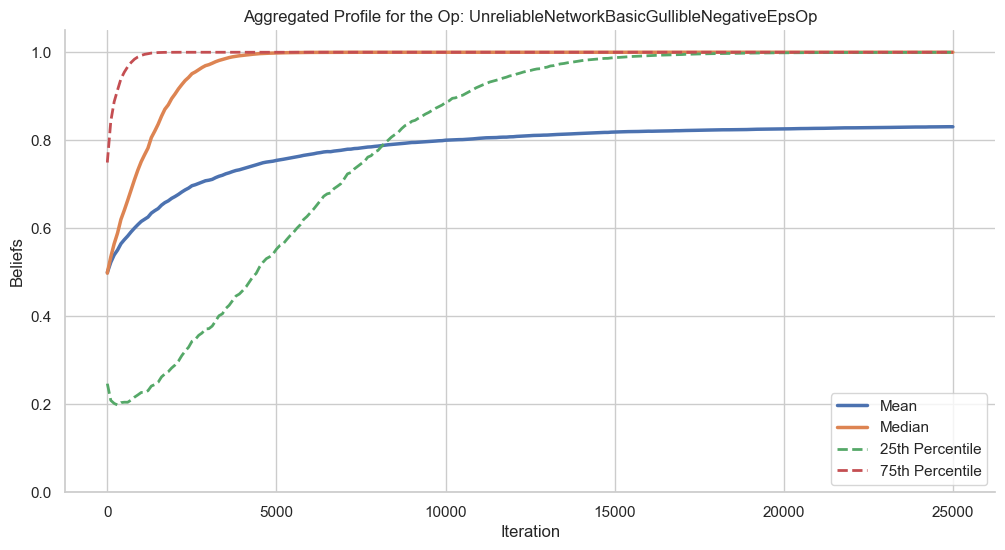

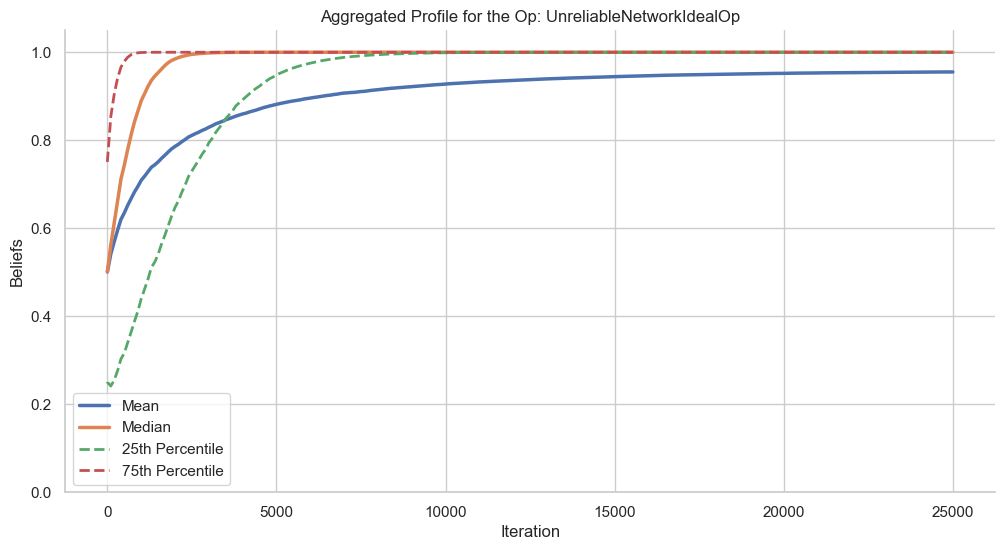

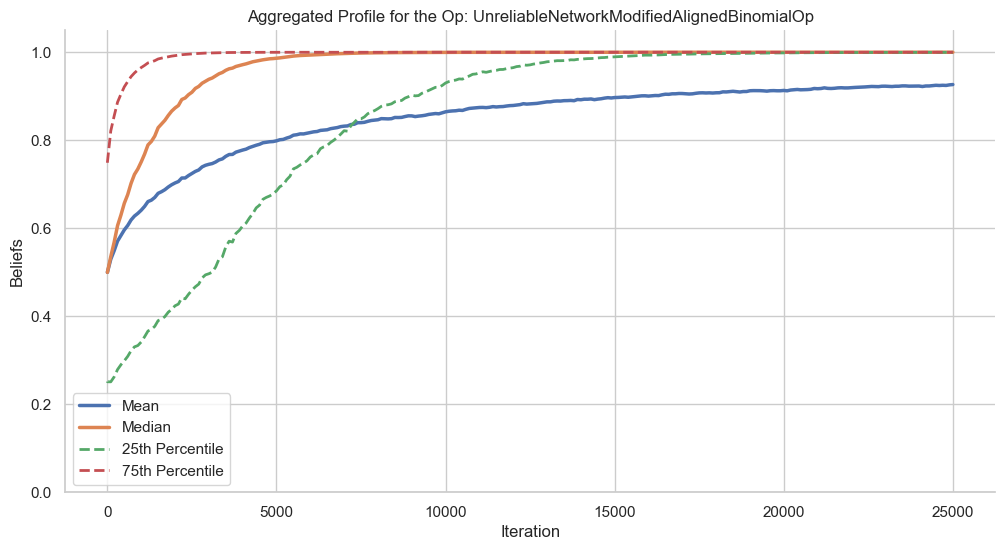

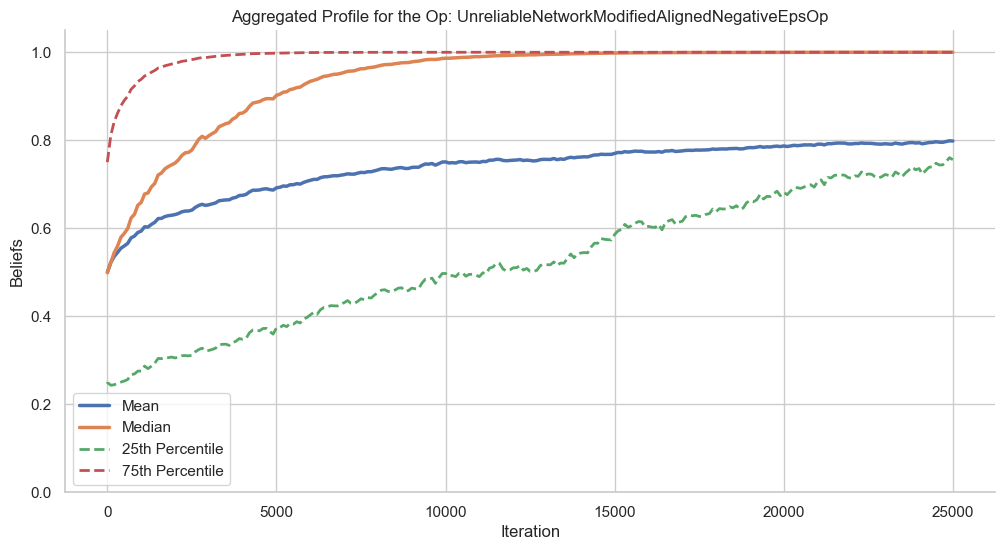

In [14]:
# Aggregated Profile for Each Operator
sns.set_theme(style="whitegrid")
unique_ops = aggregated_beliefs["op"].unique()

for op in unique_ops:
    op_data = aggregated_beliefs[aggregated_beliefs["op"] == op]
    
    plt.figure(figsize=(12, 6))
    plt.plot(op_data["iteration"], op_data["mean_beliefs"], label="Mean", lw=2.5)
    plt.plot(op_data["iteration"], op_data["median_beliefs"], label="Median", lw=2.5)
    plt.plot(op_data["iteration"], op_data["p25_beliefs"], label="25th Percentile", linestyle='--', lw=2)
    plt.plot(op_data["iteration"], op_data["p75_beliefs"], label="75th Percentile", linestyle='--', lw=2)
    
    plt.title(f"Aggregated Profile for the Op: {op}")
    plt.xlabel("Iteration")
    plt.ylabel("Beliefs")
    plt.ylim(0, 1.05)
    plt.legend()
    sns.despine()
    plt.savefig(f"images/aggregated profile for {op}.png", format="png", dpi=300, bbox_inches="tight")
    plt.savefig(f"images/aggregated profile for {op}.svg", format="svg", bbox_inches="tight")
    plt.show()


## Visualizing credences by degree centrality

/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_7451/2105130482.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  beliefs.groupby("in_degree_percentile")["beliefs"]
/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_7451/2105130482.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  beliefs.groupby("out_degree_percentile")["beliefs"]


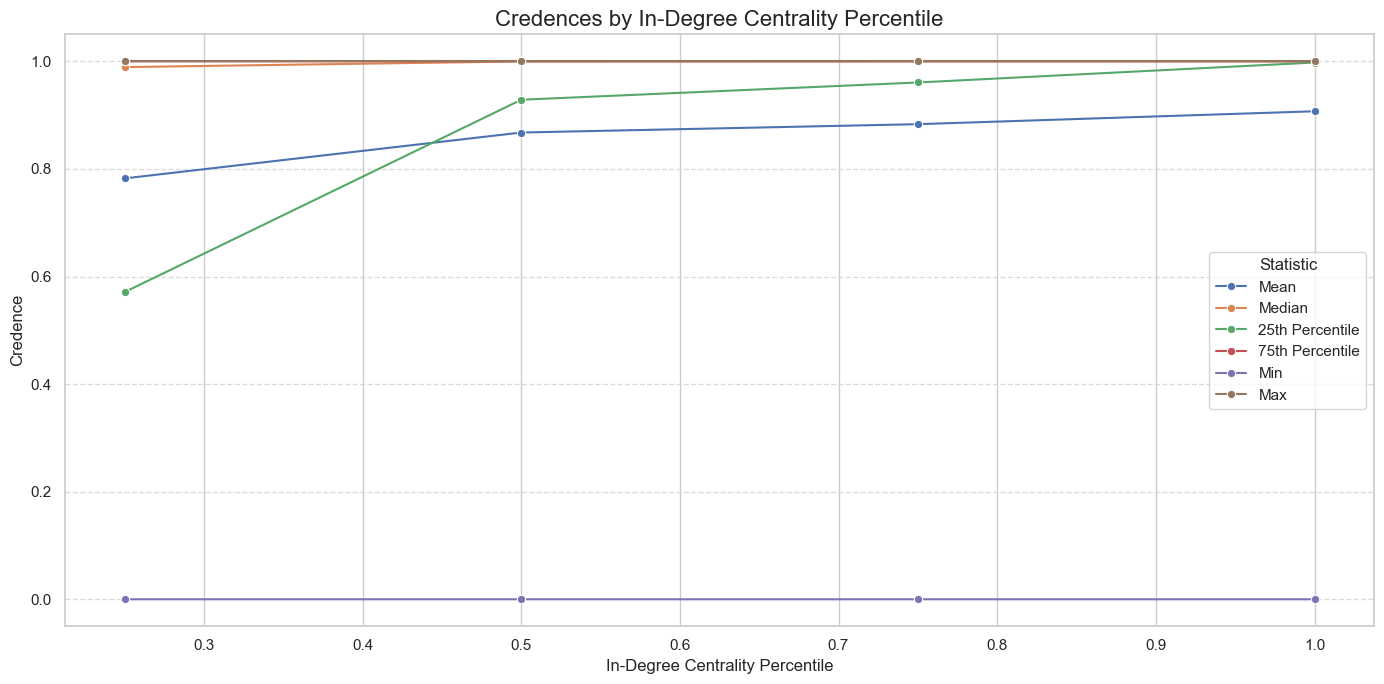

In [15]:
# Example simulation
sim_id = 99
beliefs = processor.beliefs[sim_id].reset_index()

# Build the graph for the selected simulation
graph = processor.graphs[sim_id]

# Verify if the graph is directed
if not graph.is_directed():
    graph = nx.DiGraph(graph)  # Convert to directed graph
    
# Compute in-degree and out-degree centrality
in_degree_centrality = nx.in_degree_centrality(graph)
out_degree_centrality = nx.out_degree_centrality(graph)

# Map centrality to beliefs
beliefs["in_degree_centrality"] = beliefs["node"].map(in_degree_centrality)
beliefs["out_degree_centrality"] = beliefs["node"].map(out_degree_centrality)

# Percentile bins
percentiles = [0, 0.25, 0.50, 0.75, 1.0]
beliefs["in_degree_percentile"] = pd.qcut(beliefs["in_degree_centrality"], q=percentiles, labels=percentiles[1:])
beliefs["out_degree_percentile"] = pd.qcut(beliefs["out_degree_centrality"], q=percentiles, labels=percentiles[1:])

# Compute statistics by centrality percentile
in_degree_stats = (
    beliefs.groupby("in_degree_percentile")["beliefs"]
    .agg(["mean", "median", "min", "max", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
    .rename(columns={"<lambda_0>": "25th", "<lambda_1>": "75th"})
    .reset_index()
)
out_degree_stats = (
    beliefs.groupby("out_degree_percentile")["beliefs"]
    .agg(["mean", "median", "min", "max", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
    .rename(columns={"<lambda_0>": "25th", "<lambda_1>": "75th"})
    .reset_index()
)

# Plot in-degree statistics
plt.figure(figsize=(14, 7))
sns.lineplot(data=in_degree_stats, x="in_degree_percentile", y="mean", label="Mean", marker="o")
sns.lineplot(data=in_degree_stats, x="in_degree_percentile", y="median", label="Median", marker="o")
sns.lineplot(data=in_degree_stats, x="in_degree_percentile", y="25th", label="25th Percentile", marker="o")
sns.lineplot(data=in_degree_stats, x="in_degree_percentile", y="75th", label="75th Percentile", marker="o")
sns.lineplot(data=in_degree_stats, x="in_degree_percentile", y="min", label="Min", marker="o")
sns.lineplot(data=in_degree_stats, x="in_degree_percentile", y="max", label="Max", marker="o")
plt.title("Credences by In-Degree Centrality Percentile", fontsize=16)
plt.xlabel("In-Degree Centrality Percentile", fontsize=12)
plt.ylabel("Credence", fontsize=12)
plt.legend(title="Statistic")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(f"images/credences by in-degree centrality percentile.png", format="png", dpi=300, bbox_inches="tight")
plt.savefig(f"images/credences by in-degree centrality percentile.svg", format="svg", bbox_inches="tight")
plt.show()


/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_7451/3087617041.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  beliefs.groupby("in_degree_percentile")["beliefs"]
/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_7451/3087617041.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  beliefs.groupby("out_degree_percentile")["beliefs"]
/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_7451/3087617041.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

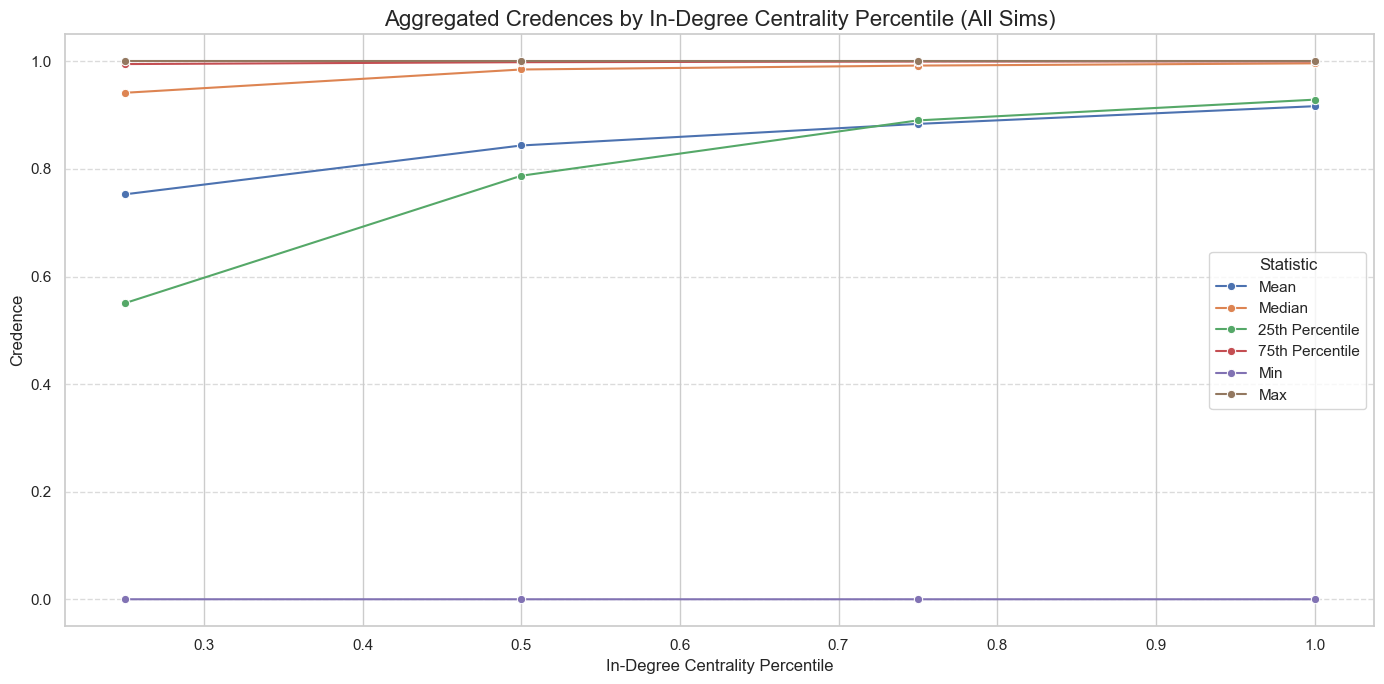

In [16]:
# Initialize DataFrame to collect results across simulations
agg_in_degree_stats = []
agg_out_degree_stats = []

for sim_id in processor.sims.index:
    # Extract beliefs and graph for this simulation
    beliefs = processor.beliefs[sim_id].reset_index()
    graph = processor.graphs[sim_id]

    # Verify if the graph is directed
    if not graph.is_directed():
        graph = nx.DiGraph(graph)  # Convert to directed graph
    
    # Compute centrality
    in_degree_centrality = nx.in_degree_centrality(graph)
    out_degree_centrality = nx.out_degree_centrality(graph)

    # Map centrality to beliefs
    beliefs["in_degree_centrality"] = beliefs["node"].map(in_degree_centrality)
    beliefs["out_degree_centrality"] = beliefs["node"].map(out_degree_centrality)

    # Assign percentiles
    beliefs["in_degree_percentile"] = pd.qcut(beliefs["in_degree_centrality"], q=percentiles, labels=percentiles[1:])
    beliefs["out_degree_percentile"] = pd.qcut(beliefs["out_degree_centrality"], q=percentiles, labels=percentiles[1:])

    # Compute stats
    in_degree_stats = (
        beliefs.groupby("in_degree_percentile")["beliefs"]
        .agg(["mean", "median", "min", "max", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
        .rename(columns={"<lambda_0>": "25th", "<lambda_1>": "75th"})
        .reset_index()
    )
    out_degree_stats = (
        beliefs.groupby("out_degree_percentile")["beliefs"]
        .agg(["mean", "median", "min", "max", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
        .rename(columns={"<lambda_0>": "25th", "<lambda_1>": "75th"})
        .reset_index()
    )

    # Append to aggregation
    agg_in_degree_stats.append(in_degree_stats)
    agg_out_degree_stats.append(out_degree_stats)

# Combine and compute means across simulations
final_in_degree_stats = pd.concat(agg_in_degree_stats).groupby("in_degree_percentile").mean().reset_index()
final_out_degree_stats = pd.concat(agg_out_degree_stats).groupby("out_degree_percentile").mean().reset_index()

# Plot aggregated stats (e.g., for in-degree)
plt.figure(figsize=(14, 7))
sns.lineplot(data=final_in_degree_stats, x="in_degree_percentile", y="mean", label="Mean", marker="o")
sns.lineplot(data=final_in_degree_stats, x="in_degree_percentile", y="median", label="Median", marker="o")
sns.lineplot(data=final_in_degree_stats, x="in_degree_percentile", y="25th", label="25th Percentile", marker="o")
sns.lineplot(data=final_in_degree_stats, x="in_degree_percentile", y="75th", label="75th Percentile", marker="o")
sns.lineplot(data=final_in_degree_stats, x="in_degree_percentile", y="min", label="Min", marker="o")
sns.lineplot(data=final_in_degree_stats, x="in_degree_percentile", y="max", label="Max", marker="o")
plt.title("Aggregated Credences by In-Degree Centrality Percentile (All Sims)", fontsize=16)
plt.xlabel("In-Degree Centrality Percentile", fontsize=12)
plt.ylabel("Credence", fontsize=12)
plt.legend(title="Statistic")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("images/aggregated credences by in-degree centrality percentile(all sims).png", format="png", dpi=300, bbox_inches="tight")
plt.savefig("images/aggregated credences by in-degree centrality percentile(all sims).svg", format="svg", bbox_inches="tight")
plt.show()
